# Facets of Mathematics - Week 10
# Regression Modelling

### Aims

By the end of this notebook you 

* should have understood how categorical variables can be incorporated in regression models
* will be able to fit multiple linear models and logistic models to data sets
* have worked with a real data set

### Topics

* Categorical Variables in Regression Models
* Multiple Linear Regression
* Logistic Regression

### References

**Montgomery, Peck, and Vining:** D. C, Montgomery, E. A. Peck, and G. G. Vining, "Introduction to Linear Regression Analysis", 5th Edition, Wiley Series in Probability and Statistics, 2012

* Multiple Linear Regression: Chapter 3, Sections 3.1 and 3.2

**Davison:** A. C. Davison, "Statistical Models", Cambridge Series in Statistical and Probabilistic Mathematics, 2008

* Linear Regression: Chapter 8
* Generalised Linear Models: Section 10.3
* Logistic Regression: Section 10.4

**Draper, Smith:** N. R. Draper, H. Smith, "Applied Regression Analysis", 3rd Edition, Wiley Series in Probability and Statistics, 1998

* Generalised Linear Models: Chapter 18
* Logistic Regression: Section 18.3

---

## Example 1 - Regression with Categorical Variables

For today's workshop we will need a few more packages and we run explicitely all the commands we need. Alternatively, one may outsource these into a separate file as we have done in the second workshop when we run the `%run setup.py` line (it allowed the lecturer to facilitate the interactive plots without confusing anyone with complicated lines of code).

In [1]:
%matplotlib inline

# Import numpy package for numeric arrays and algebraic functions 
import numpy as np

# Creating standard python plots
import matplotlib.pyplot as plt

# Creating fancier and (arguably) prettier plots
import seaborn as sns

# Statistical packages
import sklearn.metrics as sk_metrics
from sklearn import datasets
import sklearn.linear_model as sk_lm
from scipy import stats

# Storing and manipulating data
import pandas as pd

# Some commands to make the plots look nice and big.
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.markersize'] = 7
plt.rcParams['lines.linewidth'] = 2

# Function returning the RMSE, you may recognise it from the last workshop
def calc_RMSE(obs, fit, axis=1):
    return np.sqrt(np.sum((obs-fit)**2)/len(obs)) # i would use np.average((obs-fit)**2)

---

### Books Data

This data set comes from the `DAAG` package in R and it gives the measurements on the volume (in cm$^3$) and weight (in g) of 15 books, some of which are softcover and some of which are hardback. Our goal with these data is to derive a model that allows us to predict the weight of a book give its volume and cover type.

These data have been stored as variables in the `books.py` file provided with this worksheet, we will load the data using `import`.

In [2]:
from books import volume, weight, cover

book_df = pd.DataFrame({'volume':volume, 'weight':weight, 'cover':cover}) 

n = len(volume)

As with any new data the first order of business is to plot them and visually examine them for any potential relationship. 

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


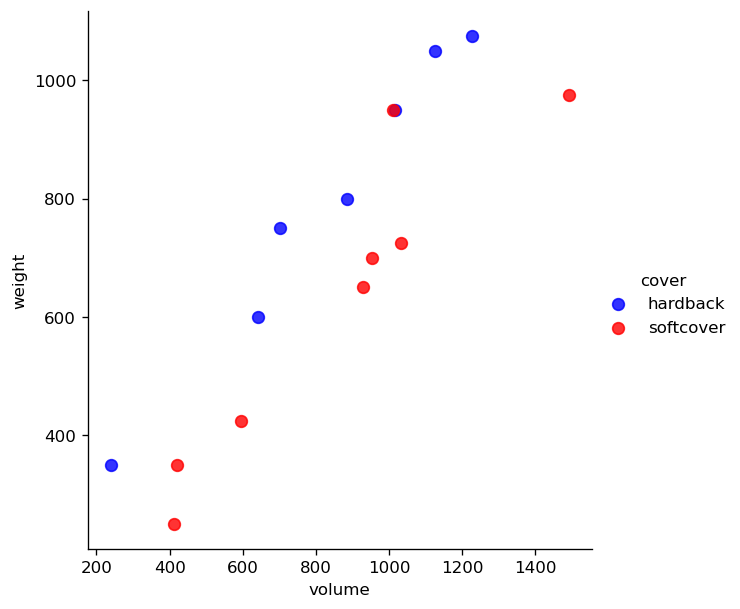

In [3]:
#Scatterplot with datapoints coloured by cover-type
sns.lmplot('volume', 'weight', data=book_df, hue='cover', fit_reg=False, palette=['b','r']) 
plt.show()

### Exercise

Based on the scatter plot above, how would you describe the relationship between the weight of the books and their volume? Does the cover type seem to play a role in this relationship?

---

We will now fit a linear regression model to these data and see what it tells us about their relationship(s). As in Example 2 of the last workshop, we will be using `sklearn`s `LinearRegression` function to fit the model and obtain our estimates for $\beta_0$ and $\beta_1$.

(107.67931061376645, 0.7086371433704163)


D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


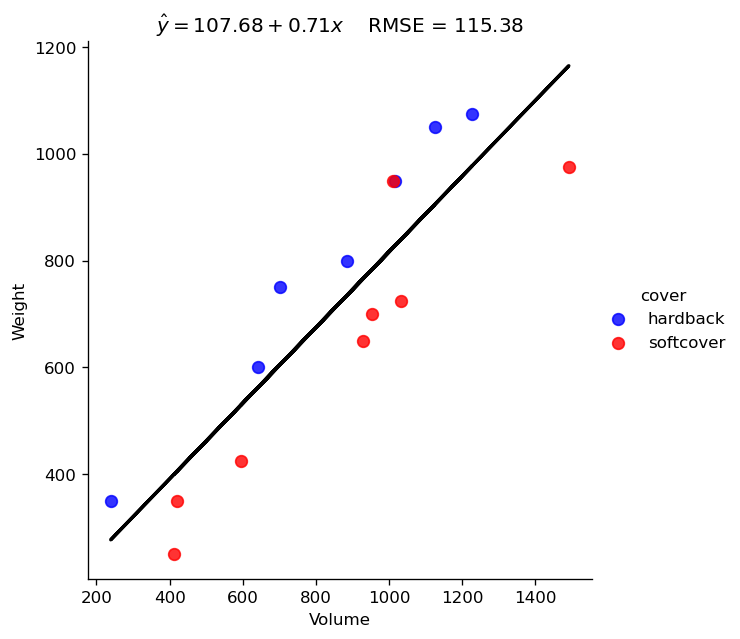

In [4]:
# Create a linear regression object we will use to fit our models 
# Note that we have set fit_intercept to False, so we will need to 
# provide the column of ones if we want an intercept coefficient.

linear_model = sk_lm.LinearRegression(fit_intercept=False)

''' Construct the design matrix '''
X = np.c_[np.ones(n), volume]     # Construct the model matrix by concatenating (putting together) an array of ones and a data array
reg = linear_model.fit(X, weight) # Fit the linear model

b0, b1 = reg.coef_                # Extract the coefficients (betas)

print((b0,b1))

''' Predict weight for observed volumes '''
y_hat = reg.predict(X)


''' Create a seaborn plot '''
sns.lmplot('volume', 'weight', data=book_df, hue='cover', fit_reg=False, palette=['b','r'])  #Scatterplot with datapoints coloured by cover-type

plt.plot(volume, y_hat, "k-") # Add regression line to scatter plot
plt.xlabel("Volume")
plt.ylabel("Weight")
plt.title("$\hat{y} = %.2f + %.2f x$    RMSE = %.2f" % (b0, b1, calc_RMSE(weight, y_hat)))
plt.show()

### Exercise

As mentioned in the lectures, a residual is the difference between the observed and predicted value, $y_i - \hat{y}_i$. Create a scatter plot of the residuals vs fitted values, based on that plot what can you say about the residuals of the hardback books vs the softcover books? What does this observation tell us about potential weaknesses of our model?

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


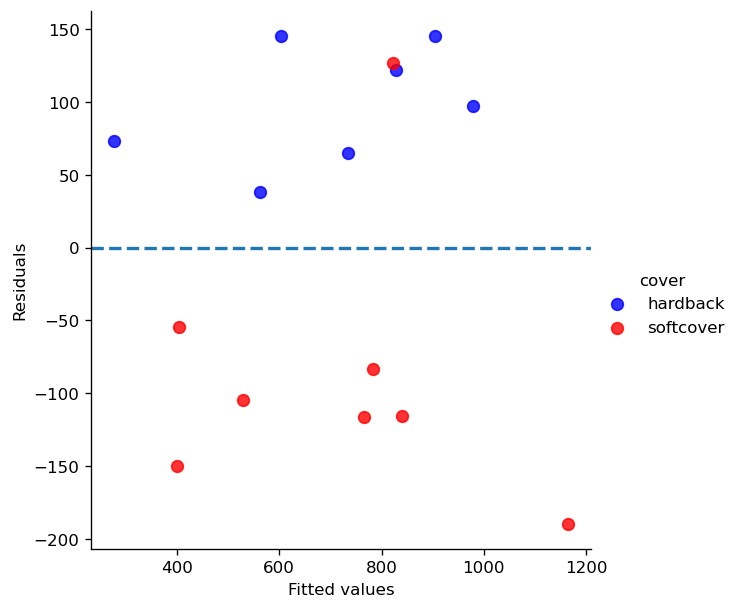

In [5]:
book_df['fitted'] = y_hat
book_df['residuals'] = book_df['weight'] - y_hat

sns.lmplot('fitted', 'residuals', data=book_df, hue='cover', fit_reg=False, palette=['b','r'])  

plt.axhline(y=0,ls="--") 
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

### Dummy Coding

Based on these results, it should be clear that it is important that our model include information about whether or not a book is a hardback or softcover. As such, we need a way of encoding this information into our modeling framework. To do this we need a way of turning our text / categorical variable into a numeric representation that can be included in our model matrix.

The most common approach for doing this is called dummy coding, in the case of a binary catergorical variable it involves picking one of the two levels of the categorical variable and encoding it as 1 and the other level as 0. With Python we can accomplish this by comparing our categorical vector to the value of our choice and then casting (converting) the result to an integer type.

For example if we wanted to code `hardback` as 1 and `softcover` as 0 we would do the following,

In [6]:
hardback = (cover == "hardback").astype(int) # Returns either 0 or 1
print(hardback)

[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]


This is equivalent to using an indicator function in mathematical notation,

$$ 
\mathbb{1}_{hb_i} = 
\begin{cases}
1 & \text {if cover of book $i$ is hardback} \\
0 & \text {if cover of book $i$ is softcover}
\end{cases}.
$$

Alternatively, we can defined the opposite of this where we code `hardback` as 0 and `softcover` as 1,



In [7]:
softcover = (cover == "softcover").astype(int)
print(softcover)

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


Now that we have recoded our categorical variable, `cover`, into a numerical variable we can fit a standard regression model with the form

$$ y_i = \beta_0 + \beta_1 \, x_i + \beta_2 \, \mathbb{1}_{hb_i}, $$

which we can represent in matrix form using,
$$\boldsymbol{y} = \boldsymbol{X} \boldsymbol{\beta}$$  
where 
$$\boldsymbol{X} = \big[ \boldsymbol{1},\, \boldsymbol{x},\, \boldsymbol{\mathbb{1}_{hb}} \big].$$

Using Python, we can use the usual concatenate function with our 1s column, the volume column, and our new dummy coded indicator column.

In [8]:
X = np.c_[np.ones(n), volume, hardback]
reg = linear_model.fit(X, weight)

b0, b1, b2 = reg.coef_
print((b0,b1,b2))

(13.915572191126039, 0.7179537437859397, 184.04727138159208)


This gives us a regression equation of the form

$$ 
y_i = 13.9 + 0.72 \, x_i + 184.0 \, \mathbb{1}_{hb_i} ,
$$

which can be rewritten as two separate line equations (one for each case of `cover`)

$$
y_i = \begin{cases}
        13.9 + 0.72 \, x_i & \text{if book cover $i$ is hardback} \\
        (13.9 + 184.0) + 0.72 \, x_i & \text{if book cover $i$ is softcover} \\
       \end{cases}.
$$

We can calculate prediction points along those lines using the following Python code in which we hard code the possible values of $\boldsymbol{\mathbb{1}_{hb_i}}$.

In [9]:
y_hat = reg.predict(X)              # Predict weights for the observed volumes

sc = b0 + b1 * volume + b2 * 0 # prediction volumes for softcover books
hb = b0 + b1 * volume + b2 * 1 # prediction volumes for hardback books

We can then plot both of these lines along with the observed data.

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


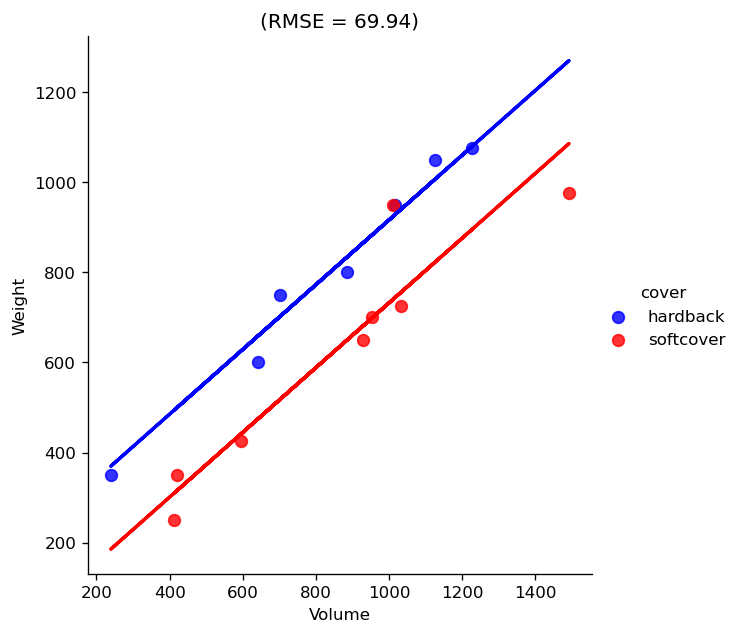

In [10]:
sns.lmplot('volume', 'weight', data=book_df, hue='cover', fit_reg=False, palette=['b','r'])
plt.plot(volume, hb, 'b-')  # Add hardback regression line
plt.plot(volume, sc, 'r-') # Add softcover regression line
plt.title("(RMSE = %.2f)" % calc_RMSE(weight, y_hat))
plt.xlabel("Volume")
plt.ylabel("Weight")
plt.show()

### Exercise 

Based on these regression fits, do you think the model including the dummy coded `cover` variable produces a "better" model than our first regression model which did not include `cover`? Explain. 

---

Note that by including a dummy variable in our model we must also change the interpretation of our regression coefficients. In this context,

* $\beta_0$ - This is the expected weight of a book with a `volume` of zero and a `hardback` indicator of zero, in other words a softcover book with zero volume.

* $\beta_1$ - This is the expected additional weight a book would have if its volume were to increase by 1 cm$^3$, all else being equal.

* $\beta_2$ - This is the expected additional weight a book would have if its hardcover indicator were to increase by 1, all else being equal. However, the hardcover indicator can only be 0 or 1 and hence this is the change in weight we would expect between a softcover book and a hardcover book with the same volume. In other words, hardcover books weight 184g more than softcover books.

Based on these interpretations we can see that the level that was coded as 0 (what is often called the reference level) gets folded into our intercept. The slope coefficient for the indicator provides the difference in intercept between the reference and the contrast level (level coded as 1).

---

### Exercise

Repeat the analysis above but this time fit a model using `softcover` instead of `hardcover` in your design matrix. You should fit the new model as well as calculate the predictions for both softcover and hardback books. Finally, create a scatter plot of the data along with the model fit. 

(197.9628435727181, 0.7179537437859432, -184.04727138159188)


D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


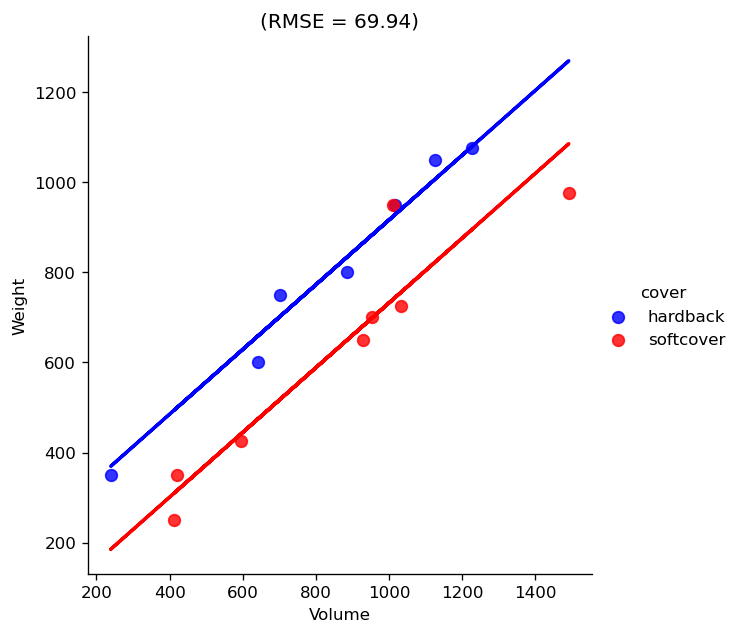

In [14]:
X = np.c_[np.ones(n), volume, softcover]
reg = linear_model.fit(X, weight)

b0, b1, b2 = reg.coef_
print((b0,b1,b2))

y_hat = reg.predict(X)              # Predict weights for the observed volumes

sc = b0 + b1 * volume + b2 * 1 # prediction volumes for softcover books
hb = b0 + b1 * volume + b2 * 0 # prediction volumes for hardback books

sns.lmplot('volume', 'weight', data=book_df, hue='cover', fit_reg=False, palette=['b','r'])
plt.plot(volume, hb, 'b-')  # Add hardback regression line
plt.plot(volume, sc, 'r-') # Add softcover regression line
plt.title("(RMSE = %.2f)" % calc_RMSE(weight, y_hat))
plt.xlabel("Volume")
plt.ylabel("Weight")
plt.show()

### &diams; Exercise &diams;

What changed between the model with `softcover` vs the model with `hardcover`? Specifically, comment on the values of $\beta_0$, $\beta_1$, and $\beta_2$ and their interpretations.

---

Now lets consider the model where we naievely include both `hardback` and `softcover` as predictors in our model.

(70.62613858794802, 0.7179537437859418, 127.33670498477, -56.71056639682191)


D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


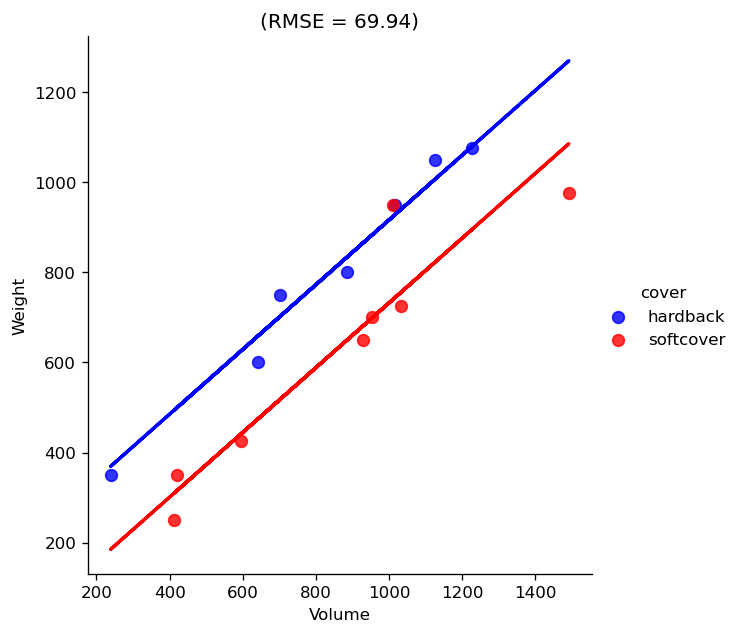

In [15]:
X = np.c_[np.ones(n), volume, hardback, softcover]
reg = linear_model.fit(X, weight)

b0, b1, b2, b3 = reg.coef_
print( (b0, b1, b2, b3) )


y_hat = reg.predict(X)

hb = b0 + b1 * volume + b2 * 1 + b3 * 0
sc = b0 + b1 * volume + b2 * 0 + b3 * 1

sns.lmplot('volume', 'weight', data=book_df, hue='cover', fit_reg=False, palette=['b','r'])
plt.plot(volume, hb, 'b-')  # Add hardback regression line
plt.plot(volume, sc, 'r-') # Add softcover regression line
plt.title("(RMSE = %.2f)" % calc_RMSE(weight, y_hat))
plt.xlabel("Volume")
plt.ylabel("Weight")
plt.show()

### Exercise 

Write out the equations that predict weight for hardback and softcover books according to this model.  

---

### Question 

Are the solutions given above unique? Can you find different values of $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ that would give you the same regression equations you wrote out in the exercise earlier (marked with a diamond &diams;)?

---

## Example 2

This is an example with real data, taken from *Davison*. The aim of the experiment conducted was to see if butterflies have better protection from being eaten if their wings are marked with different colours. Data was collected for six different species and eight different colours. It was then checked if the butterflies were either 
* not sampled by the predator at all,
* sampled by the predator but not eaten, or
* eaten. 

We firstly load the data stored in separate files, one for each species. We print the first species and all data.

In [16]:
import numpy as np

''' Load data for each butterfly species '''
aphrissa_boisduvalli = np.load('rm_aphrissa_boisduvalli.npy')
phoebis_argante = np.load('rm_phoebis_argante.npy')
dryas_iulia = np.load('rm_dryas_iulia.npy')
pierella_luna = np.load('rm_pierella_luna.npy')
consul_fabius = np.load('rm_consul_fabius.npy')
siproeta_stelenes = np.load('rm_siproeta_stelenes.npy')

print('Aphrissa Boisduvalli: ',aphrissa_boisduvalli)
print('\nAll species:: ',np.c_[aphrissa_boisduvalli,phoebis_argante,dryas_iulia,pierella_luna,consul_fabius,siproeta_stelenes])

Aphrissa Boisduvalli:  [[ 0  0 14]
 [ 7  1  2]
 [ 7  2  1]
 [ 6  0  0]
 [ 3  0  1]
 [ 4  0  0]
 [ 4  2  0]
 [ 4  0  0]]

All species::  [[ 0  0 14  6  1  0  1  0  2  4  1  5  0  0  0  0  0  1]
 [ 7  1  2  2  1  0  1  0  1  2  2  4  0  0  3  0  0  1]
 [ 7  2  1  4  0  2  5  0  1  2  0  5  0  0  1  0  0  3]
 [ 6  0  0  0  0  0  0  0  1  4  0  3  0  0  1  0  1  1]
 [ 3  0  1  1  1  0  5  0  0  6  0  2  0  0  1  0  0  3]
 [ 4  0  0  0  0  0  6  0  0  4  0  2  0  0  1  3  0  1]
 [ 4  2  0  6  0  0  4  1  1  7  0  1  0  0  2  1  1  1]
 [ 4  0  0  0  0  0  1  0  1  4  2  2  7  1  0  0  1  0]]


We will be interested in whether the colours increase the *probability* of the species being eaten, and aggregate all the different butterfly species to one. We then sum the first two columns, as both the 'not sampled' and the 'sampled and rejected' columns correspond to 'not eaten'.

The data is then printed together with the row labels.

In [17]:
''' Aggregate data '''
all_butterflies = aphrissa_boisduvalli+phoebis_argante+dryas_iulia+pierella_luna+consul_fabius+siproeta_stelenes

''' Sum first the first two rows (corresponding to "N" and "S") to get the "Not eaten" column '''
not_eaten = all_butterflies[:,0]+all_butterflies[:,1]

''' "Eaten column" is the third column of the all_butterflies matrix '''
eaten = all_butterflies[:,2]

data = np.c_[not_eaten,eaten]
data = data.transpose()

print('             NE  E')
print('Unpainted: ',data[:,0])
print('Brown:     ',data[:,1])
print('Yellow:    ',data[:,2])
print('Blue:      ',data[:,3])
print('Green:     ',data[:,4])
print('Red:       ',data[:,5])
print('Orange:    ',data[:,6])
print('Black:     ',data[:,7])

             NE  E
Unpainted:  [13 22]
Brown:      [16 11]
Yellow:     [20 13]
Blue:       [11  6]
Green:      [16  7]
Red:        [17  4]
Orange:     [26  5]
Black:      [20  3]


We are interested in the probability of being eaten, so need to transpose the data. We initialise the response and the predictor matrix as follows:

In [57]:
data.transpose()
print(data)

y = np.zeros(8) # 8 colours
X = np.eye(8) # dummy variables
for i in range(8):
    y[i] = data[1,i]/(data[0,i]+data[1,i]) # probability eaten
    
print('\nResponses: ',y)
print('\nDesign matrix: ',X)

[[13 16 20 11 16 17 26 20]
 [22 11 13  6  7  4  5  3]]

Responses:  [0.62857143 0.40740741 0.39393939 0.35294118 0.30434783 0.19047619
 0.16129032 0.13043478]

Design matrix:  [[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


### Question

If one is very precise, we would have a data point for each butterfly. If e.g. the $i$-th bubtterfly is blue and eaten, the butterfly would have the response $y_i=1$ and the predictor $(0,0,0,1,0,0,0,0)$. Check that the response vector and design matrix above result in the same estimate $\hat\beta$.

---
We now run the file 'IRLS.py' which contains an iterative solver to get a least squares estimate for the logistic regression problem.

### Exercise
Check the file 'IRLS.py'. The iterative solver starts at a given point $\beta^{(0)}$, and iteratively updates this estimate $\beta^{(k)}$. Write down the mathematical expression for $\beta^{(k)}$. When does the iterative algorithm stop?


In [47]:
%run IRLS.py

<Figure size 960x600 with 0 Axes>

### Exercise
Choose different start vectors and find the least squares estimates using `beta_hat = IRLS(beta_start,X,y)`. Do the results change depending on the start points chosen?

Print the responses $y$ and the transformed probabilities $\mu_i = \frac{1}{1+\exp(-X_{i,:}^T\beta^{(k)})}$. What can you say about the resulting estimate $\hat\beta$?

In [58]:
beta_start1 = np.ones(8)
beta_hat_LL1 = IRLS(beta_start1,X,y)
print('beta_hat_LL1 = ',beta_hat_LL1)

beta_start2 = np.zeros(8)
print(y)
beta_hat_LL2 = IRLS(beta_start2,X,y)
print('beta_hat_LL2 = ',beta_hat_LL2)

beta_start3 = np.ones(8)*0.5
beta_hat_LL3 = IRLS(beta_start3,X,y)
print('beta_hat_LL3 = ',beta_hat_LL3)

beta_start4 = -np.zeros(8)*0.7
beta_hat_LL4 = IRLS(beta_start4,X,y)
print('beta_hat_LL4 = ',beta_hat_LL4)

''' Let us also look at the transformed estimates (i.e. the probabilities) '''
probs = np.zeros(8)
for i in range(8):
    probs[i] = 1/(1+np.exp(-np.dot(beta_hat_LL1,X[i,:])))
print('\nProbabilities = ',probs)

''' Compare this to the input values '''
print('Reponses = ',y)

beta_hat_LL1 =  [ 0.5260931  -0.37469345 -0.43078292 -0.6061358  -0.82667857 -1.44691898
 -1.64865863 -1.89711998]
[0.62857143 0.40740741 0.39393939 0.35294118 0.30434783 0.19047619
 0.16129032 0.13043478]
beta_hat_LL2 =  [ 0.5260931  -0.37469345 -0.43078292 -0.6061358  -0.82667857 -1.44691898
 -1.64865863 -1.89711998]
beta_hat_LL3 =  [ 0.5260931  -0.37469345 -0.43078292 -0.6061358  -0.82667857 -1.44691898
 -1.64865863 -1.89711998]
beta_hat_LL4 =  [ 0.5260931  -0.37469345 -0.43078292 -0.6061358  -0.82667857 -1.44691898
 -1.64865863 -1.89711998]

Probabilities =  [0.62857143 0.40740741 0.39393939 0.35294118 0.30434783 0.19047619
 0.16129032 0.13043478]
Reponses =  [0.62857143 0.40740741 0.39393939 0.35294118 0.30434783 0.19047619
 0.16129032 0.13043478]



---

## Example 3
Let us now consider a logistic regression example with continuous predictors. Load the predictors stored in the file 'rm3_ex4_x.npy', and the responses from  'rm3_ex4_y.npy'. The data describes how likely students are to pass an exam, depending on how many hours they spend per week listening to the lectures (variable $x_1$) and how many hours they spend on the workshops (variable $x_2$). 

### Exercise
Create a figure with two subplots, one plotting the responses against the first predictor, the second one the reponses against the second predictor. What correlations can you see in the data?

40 (40, 2)


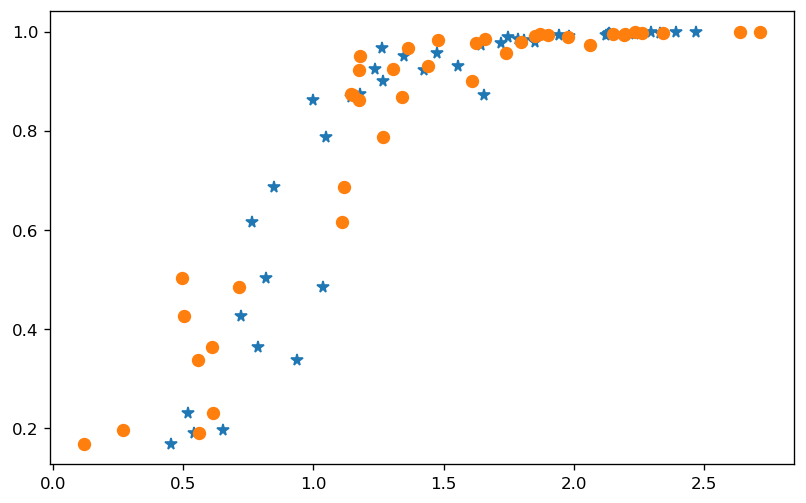

In [61]:
x = np.load('rm3_ex4_x.npy')
y = np.load( 'rm3_ex4_y.npy')
#print(x,x[:,0])
#sns.lmplot('volume', 'weight', data=book_df, hue='cover', fit_reg=False, palette=['b','r'])
plt.plot(x[:,0], y, '*')

print(len(y),x.shape)
plt.plot(x[:,1], y, 'o')


### Exercise
The next step is the regression analysis. To this end, define the design matrix with an intercept, and the two variables. Run the line `%run IRLS.py` which allows you to call the iteratively reweighted least squqres (IRLS) algorithm using the lines
`beta_hat = IRLS(beta_start,X,y)` with an appropriate start vector $\beta_{start}$. Print the resulting estimates for different values of $\beta_{start}$.

In [70]:
# Insert Code
n=len(y)
X = np.c_[np.ones(n),x]
beta_start=np.zeros(3)
beta_hat1 = IRLS(beta_start,X,y)
print(beta_hat1)
beta_start=np.ones(3)
beta_hat2 = IRLS(beta_start,X,y)
print(beta_hat2)
beta_start=-np.ones(3)*0.5
beta_hat3 = IRLS(beta_start,X,y)
print(beta_hat3)

[-3.31281127  2.18015313  2.02136675]
[ 67.62409697  -2.62525774 -33.09439749]
[-134.77323124  178.11361673    8.19376497]


Note that, depending on the choice of $\beta_{start}$, we get different estimates for $\hat\beta$. 

### Exercise 
To see which estimates are sensible, transform the estimates in probabilities through $\hat y_i = \frac{1}{1+\exp(-X_{i,:}^T\hat\beta)}$ for the respective estimates $\hat\beta$, and compare them to the given data points by computing the RMSE $\sqrt{\frac1n\sum_{i=1}^n(y_i-\hat y_i)^2}$.

In [73]:
y_hat1 = 1/(1+np.exp(-np.dot(beta_hat1,X.T)))
rmse1 = np.sqrt(np.average(y-y_hat1)**2)
print (rmse1)
y_hat2 = 1/(1+np.exp(-np.dot(beta_hat2,X.T)))
rmse2 = np.sqrt(np.average(y-y_hat2)**2)

print (rmse2)
y_hat3 = 1/(1+np.exp(-np.dot(beta_hat3,X.T)))
rmse3 = np.sqrt(np.average(y-y_hat3)**2)

print (rmse3)
 

2.511879593214417e-16
0.07796541224765377
0.08076154338043091


(40,)


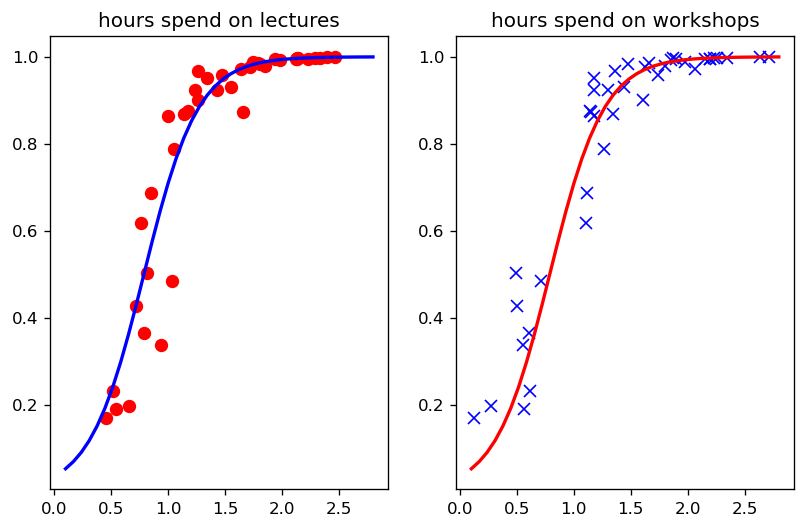

In [80]:
# Insert Code
rm3x = np.load("rm3_ex4_x.npy")
rm3y = np.load("rm3_ex4_y.npy")
print(rm3y.shape)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(rm3x[:, 0], rm3y, 'r o')
ax1.set_title('hours spend on lectures')
ax2.plot(rm3x[:, 1], rm3y, 'b x')
ax2.set_title('hours spend on workshops')

x_vals = np.c_[np.ones(40), np.linspace(0.1,2.8,40),np.linspace(0.1,2.8,40)]
y_vals = 1/(1+np.exp(-np.dot(x_vals, beta_hat1)))

ax1.plot(np.linspace(0.1,2.8,40), y_vals, 'b-' )
ax2.plot(np.linspace(0.1,2.8,40), y_vals, 'r-' )
